In [ ]:
# default_exp detectron2_detector

# detect

> Pose Detector class based on Detectron2 and some pose modification tools

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%pip install pyyaml

# Install the latest version of PyTorch availale for your machine

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#%pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# Or build it from source
%pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install DensePose project, allows it to be imported as densepose
%pip install git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose

#%pip install wget
#import wget
#wget.download("https://raw.githubusercontent.com/facebookresearch/detectron2/main/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml")
#wget.download("https://raw.githubusercontent.com/facebookresearch/detectron2/main/projects/DensePose/configs/Base-DensePose-RCNN-FPN.yaml")

# exit(0)  # After installation, you may need to restart the runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import densepose

from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)

In [ ]:
import matplotlib.pyplot as plt

def just_image(ima):
    w,h = plt.figaspect(ima)
    fig, ax = plt.subplots(figsize=(w*2, h*2), dpi=72)
    fig.subplots_adjust(0,0,1,1)
    plt.axis('off')
    ax.imshow(ima)
    plt.show()

In [ ]:
from PIL import Image
im = cv2.imread("sample_data/sample1.png")

In [ ]:
# Steps for basic COCO keypoint detection
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_image = out.get_image()
just_image(out_image)

In [ ]:
# Build project-specific config
cfg = get_cfg()
densepose.add_densepose_config(cfg)
cfg.merge_from_file("configs/densepose_rcnn_R_50_FPN_s1x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set threshold for this model
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
predictor = DefaultPredictor(cfg)

visualizers = [DensePoseResultsContourVisualizer(cfg=cfg), DensePoseResultsUVisualizer(cfg=cfg), ScoredBoundingBoxVisualizer(cfg=cfg)]
extractors = [create_extractor(visualizer) for visualizer in visualizers]
extractor = CompoundExtractor(extractors)
visualizer = CompoundVisualizer(visualizers)

In [ ]:
im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR) # Detector expects BGR format
outputs = predictor(im)["instances"]
data = extractor(outputs)

In [ ]:
image_vis = visualizer.visualize(im, data)
just_image(image_vis)

In [ ]:
#export
import torch

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import densepose

from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)

import PIL
import cv2
import os

import matplotlib.pyplot as plt

%matplotlib inline

def just_image(ima):
    w,h = plt.figaspect(ima)
    fig, ax = plt.subplots(figsize=(w*2, h*2), dpi=72)
    fig.subplots_adjust(0,0,1,1)
    plt.axis('off')
    ax.imshow(ima)
    plt.show()
    

class Detector:
    """Given a still image (or video frame), finds poses.
    
    Attributes:  
    """
    
    def __init__(self):
        
        try:
            self.device = torch.device('cuda')  # if cuda is available
        except:
            self.device = torch.device('cpu')
        
        cfg = get_cfg()
        densepose.add_densepose_config(cfg)
        cfg.merge_from_file("configs/densepose_rcnn_R_50_FPN_s1x.yaml")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set threshold for this model
        cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
        self.predictor = DefaultPredictor(cfg)

        visualizers = [DensePoseResultsContourVisualizer(cfg=cfg), DensePoseResultsUVisualizer(cfg=cfg), ScoredBoundingBoxVisualizer(cfg=cfg)]
        extractors = [create_extractor(visualizer) for visualizer in visualizers]
        self.extractor = CompoundExtractor(extractors)
        self.visualizer = CompoundVisualizer(visualizers)

#     def __detect_one_or_more_images__(self, batch):
#         data = openpifpaf.datasets.PilImageList(batch, preprocess=self.__preprocess__)
#         batch_size = len(batch)

#         loader = torch.utils.data.DataLoader(
#             data, batch_size=batch_size, pin_memory=True, 
#             collate_fn=openpifpaf.datasets.collate_images_anns_meta)

#         for images_batch, _, __ in loader:
#             detections = self.processor.batch(self.net, images_batch, device=self.device)[0]
  
#         return detections

    def __detect_image_array__(self, image_array):
        im = cv2.cvtColor(image_array, cv2.COLOR_RGBA2BGR) # Detector expects BGR format
        outputs = self.predictor(im)["instances"]
        data = self.extractor(outputs)
        return data
    
    def detect_image(self, image_path, viz=False):
        """ Applies the pose detection model to a single image file. Returns detections. """
        image_array = cv2.imread(image_path)
        
        data = self.__detect_image_array__(image_array)
        
        if viz:
            image_vis = self.visualizer.visualize(image_array, data)
            display_image = cv2.cvtColor(image_vis, cv2.COLOR_RGBA2BGR)
            just_image(display_image)
        
        return data
    
    def __draw_detections__(self, image_array, data):
        image_vis = self.visualizer.visualize(image_array, data)
        return image_vis
    
    def detect_video(self, video_file, start_seconds=0.0, end_seconds=0.0, max_frames=0, seconds_to_skip=0.0, images_too=False, write_images=False, folder_name='video_folder'):
        """ Given a video file, extracts video frames as images at `seconds_to_skip` intervals,
            from `start_seconds` to `end_seconds`, and runs `__detect_one_or_more_images__()` on each.
            Returns a list of frame pose data items, which are dictionaries with the following elements:
            { 'frame_id': <the frame's position in this list (not in the entire video, if seconds_to_skip != 0)>, 
              'time': <the frame's timecode within the excerpt (not within the full video, if start_seconds != 0)>,
              'figures': [<OpenPifPaf pose detection objects> for all figures detected in the frame]
              <OPTIONAL> 'image': <a PIL image object for the frame>
            }
            `write_images`, if true, causes the extracted frame images to be written to a folder
            specified by `folder_name`, with the naming scheme `image00001.png`
        """
        
        cap = cv2.VideoCapture(video_file)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('total frames in video:',total_frames)

        video_framerate = cap.get(cv2.CAP_PROP_FPS)
        print('video FPS:',video_framerate)
        frame_duration = 1 / float(video_framerate)

        frame_count = 0.0
        frames_processed = 0
        timecode = 0.0
        skip_until = start_seconds

        pose_output = []

        if write_images:
            if not os.path.isdir(folder_name):
                os.mkdir(folder_name)
            for filename in os.listdir(folder_name):
                file_path = os.path.join(folder_name, filename)
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)

        while cap.isOpened() and (frame_count < total_frames):
            ret_val, im = cap.read()

            timecode = frame_count * frame_duration
            frame_count += 1

            if (end_seconds and timecode > end_seconds) or (max_frames and frames_processed >= max_frames):
                return pose_output

            if timecode < start_seconds:
                continue

            if im is None:
                # Might want to retry here
                # print("Missed a frame, continuing...")
                # For now, we'll count a missed frame as a processed frame
                continue

            if seconds_to_skip and timecode < skip_until:
                continue
            else:
                skip_until += seconds_to_skip

            im_height, im_width, im_channels = im.shape

            frame_id = int(round(cap.get(1)))

            #pil_image = PIL.Image.fromarray(im)
            #detections = self.__detect_one_or_more_images__([pil_image])
            
            detections = self.__detect_image_array__(im)

            print("Frame",frame_count,"of",total_frames,round(timecode,2),"figures",len(detections))

            this_frame_data = {'frame_id': frame_count, 'time': timecode, 'figures': detections} #, 'flipped_figures': flipped_detections, 'zeroified_figures': zeroified_detections}
            if images_too:
                this_frame_data['image'] = im
            if write_images:
                if write_images:
                    output_image_array = self.__draw_detections__(im, this_frame_data['figures'])
                    # Image doesn't necessarily come in as RGB(A)!
                    #rgbim = cv2.cvtColor(output_image_array, cv2.COLOR_BGR2RGBA)
                    pil_image = PIL.Image.fromarray(output_image_array)
                    pil_image.save(os.path.join(folder_name, 'image' + str(int(frames_processed + 1)).zfill(5) + '.png'), 'PNG')

            pose_output.append(this_frame_data)
            frames_processed += 1

        return pose_output

In [ ]:
show_doc(Detector.detect_image)
show_doc(Detector.detect_video)

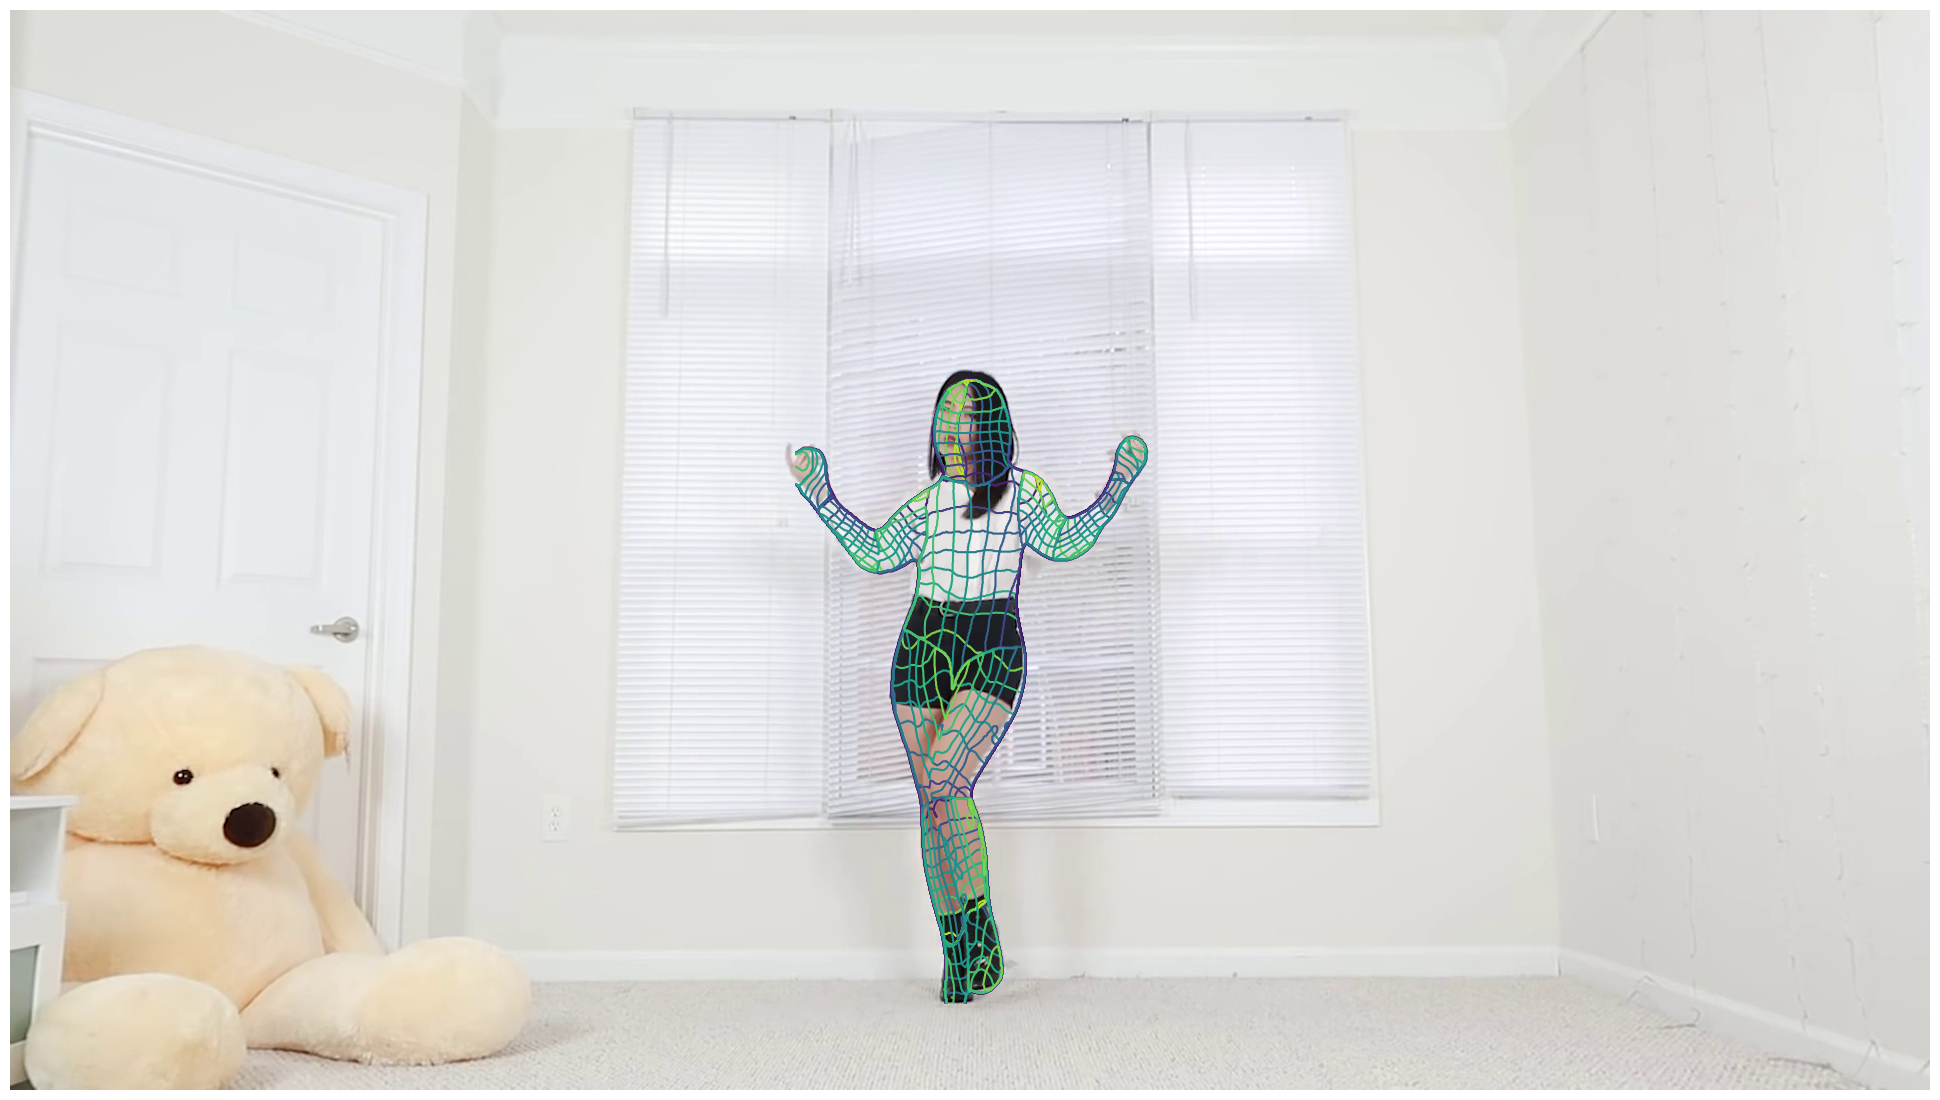

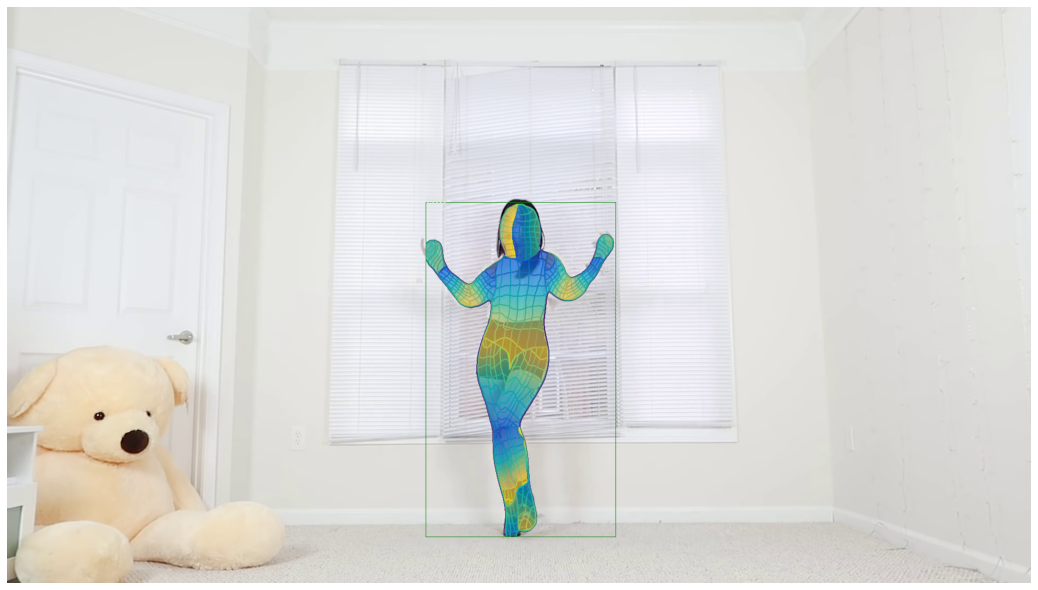

In [ ]:
teddy = Detector()
detections = teddy.detect_image('sample_data/sample1.png', viz=True)

In [ ]:
import pickle
teddy = Detector()
pose_output = teddy.detect_video("/srv/choreo/Einstein.mp4", start_seconds=6310, end_seconds=7288, write_images=True, images_too=False)
pickle.dump(pose_output, open("theater_videos/Einstein_Ballet_6310_to_7288.p", "wb"))

In [ ]:
FPS = 25
!ffmpeg -y -framerate $FPS -pattern_type glob -i 'video_folder/*.png' -strict '-2' -c:v libx264 -vf "fps=$FPS" -pix_fmt yuv420p Einstein_Ballet_DensePose.mp4

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/broadwell/anaconda3/envs/torch --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.

In [ ]:
try:
    teddy = Detector()
    detections = teddy.detect_image('sample_data/sample1.png')
    print(detections[0])
except:
    print("Unable to instantiate a detector on your system. Do you have PyTorch with CUDA enabled?")